In [1]:
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [2]:
protoPath = "face_recog/face_detection_model/deploy.prototxt"

modelPath = "face_recog/face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk

embedder = cv2.dnn.readNetFromTorch("face_recog/openface_nn4.small2.v1.t7")

Embedder : This model is Torch-based and is responsible for extracting facial embeddings via deep learning feature extraction.

detector : We’re using a Caffe based DL face detector to localize faces in an image.

In [3]:
imagePaths = []
main_dir = 'Image Dataset'
main_dir_list = os.listdir(main_dir)
for name in main_dir_list:
    name_dir = os.path.sep.join([main_dir, name])
    name_dir_list = os.listdir(name_dir)
    for image in name_dir_list:
        imagePath = os.path.sep.join([main_dir, name, image])
        imagePaths.append(imagePath)

Image Paths

In [4]:
for i in imagePaths:
    print(i.split(os.path.sep)[-2], " : ",i)
    print()

Aviral  :  Image Dataset\Aviral\1.jpeg

Aviral  :  Image Dataset\Aviral\2.jpeg

Aviral  :  Image Dataset\Aviral\3 - Copy.jpeg

Aviral  :  Image Dataset\Aviral\3.jpeg

Aviral  :  Image Dataset\Aviral\4.jpeg

Aviral  :  Image Dataset\Aviral\aviral_1.png

Aviral  :  Image Dataset\Aviral\aviral_14png.png

Aviral  :  Image Dataset\Aviral\aviral_2.png

Aviral  :  Image Dataset\Aviral\aviral_3.png

Aviral  :  Image Dataset\Aviral\aviral_5.png

Pranjal  :  Image Dataset\Pranjal\1.jpeg

Pranjal  :  Image Dataset\Pranjal\2.jpeg

Pranjal  :  Image Dataset\Pranjal\3.jpeg

Pranjal  :  Image Dataset\Pranjal\4.jpeg

Pranjal  :  Image Dataset\Pranjal\5.jpeg

Priyansh  :  Image Dataset\Priyansh\me_1.png

Priyansh  :  Image Dataset\Priyansh\me_2.png

Priyansh  :  Image Dataset\Priyansh\me_3.png

Priyansh  :  Image Dataset\Priyansh\me_4.png

Priyansh  :  Image Dataset\Priyansh\me_5.png

Priyansh Soni  :  Image Dataset\Priyansh Soni\soni_1 - Copy.png

Priyansh Soni  :  Image Dataset\Priyansh Soni\soni_1.p

# Extract embeddings from face dataset

In [5]:
# initialize our lists of extracted facial embeddings and corresponding people names
knownEmbeddings = []
knownNames = []
# initialize the total number of faces processed
total = 0
i = 0

In [7]:
for i in range(len(imagePaths)):
    
    imagePath = imagePaths[i]
    # extract the person name from the image path
    print("[INFO] processing image {}/{}".format(i + 1, len(imagePaths)))
    name = imagePath.split(os.path.sep)[-2]
    
    # load the image, resize it to have a width of 600 pixels (while maintaining the aspect ratio), and then grab the image
    # dimensions
    
    image = cv2.imread(imagePath)
    (h, w) = image.shape[:2]
    
    # construct a blob from the image
    
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0),
                                      swapRB=False, crop=False)
    
    # apply OpenCV's deep learning-based face detector to localize faces in the input image
    
    detector.setInput(imageBlob)
    detections = detector.forward()
    
    if len(detections) > 0:
        
        # we're making the assumption that each image has only ONE face, so find the bounding box with the largest probability
        
        i = np.argmax(detections[0, 0, :, 2])
        confidence = detections[0, 0, i, 2]
        
        # ensure that the detection with the largest probability also
        # means our minimum probability test (thus helping filter out
        # weak detections)
        
        if confidence > 0.5:
        
            # compute the (x, y)-coordinates of the bounding box for the face
        
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # extract the face ROI and grab the ROI dimensions
            
            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]
            
            # ensure the face width and height are sufficiently large
            
            if fW < 20 or fH < 20:
                continue
            
            # construct a blob for the face ROI, then pass the blob through our face embedding model to obtain the 128-d
            # quantification of the face
            
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()
            
            # add the name of the person + corresponding face
            # embedding to their respective lists
            
            knownNames.append(name)
            knownEmbeddings.append(vec.flatten())
            total += 1

[INFO] processing image 1/30
[INFO] processing image 2/30
[INFO] processing image 3/30
[INFO] processing image 4/30
[INFO] processing image 5/30
[INFO] processing image 6/30
[INFO] processing image 7/30
[INFO] processing image 8/30
[INFO] processing image 9/30
[INFO] processing image 10/30
[INFO] processing image 11/30
[INFO] processing image 12/30
[INFO] processing image 13/30
[INFO] processing image 14/30
[INFO] processing image 15/30
[INFO] processing image 16/30
[INFO] processing image 17/30
[INFO] processing image 18/30
[INFO] processing image 19/30
[INFO] processing image 20/30
[INFO] processing image 21/30
[INFO] processing image 22/30
[INFO] processing image 23/30
[INFO] processing image 24/30
[INFO] processing image 25/30
[INFO] processing image 26/30
[INFO] processing image 27/30
[INFO] processing image 28/30
[INFO] processing image 29/30
[INFO] processing image 30/30


In [8]:
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open('Trined_Embeddings', "wb")
f.write(pickle.dumps(data))
f.close()

# Train face recognition model

In [9]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import pickle
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [12]:
model = Sequential([Dense(128, input_shape = (128,), activation = 'relu'),
                    Dense(64, activation = 'relu', kernel_initializer = 'he_uniform'),
                    Dense(64, activation = 'relu',  kernel_initializer = 'he_uniform'),
                    Dense(32, activation = 'relu',  kernel_initializer = 'he_uniform'),
                    Dense(32, activation = 'relu',  kernel_initializer = 'he_uniform'),
                    Dense(5, activation = 'softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam' ,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 165       
Total params: 32,229
Trainable params: 32,229
Non-trainable params: 0
__________________________________________________

In [13]:
data = pickle.loads(open('Trined_Embeddings', "rb").read())

le = LabelEncoder()
labels = le.fit_transform(data["names"])

In [14]:
embeddings = data["embeddings"]
embeddings = np.array(embeddings)

In [15]:
h = model.fit(embeddings, labels, epochs = 50)

Epoch 1/50
30/30 [==============================] - 1s 31ms/step - loss: 1.6212 - accuracy: 0.1000
Epoch 2/50
30/30 [==============================] - 0s 399us/step - loss: 1.6002 - accuracy: 0.2333
Epoch 3/50
30/30 [==============================] - 0s 360us/step - loss: 1.5826 - accuracy: 0.3333
Epoch 4/50
30/30 [==============================] - 0s 354us/step - loss: 1.5665 - accuracy: 0.3000
Epoch 5/50
30/30 [==============================] - 0s 417us/step - loss: 1.5498 - accuracy: 0.3333
Epoch 6/50
30/30 [==============================] - 0s 369us/step - loss: 1.5328 - accuracy: 0.3333
Epoch 7/50
30/30 [==============================] - 0s 470us/step - loss: 1.5151 - accuracy: 0.3333
Epoch 8/50
30/30 [==============================] - 0s 371us/step - loss: 1.4971 - accuracy: 0.3667
Epoch 9/50
30/30 [==============================] - 0s 464us/step - loss: 1.4789 - accuracy: 0.4000
Epoch 10/50
30/30 [==============================] - 0s 438us/step - loss: 1.4599 - accuracy: 0.4667


In [16]:
# write the actual face recognition model to disk
model.save('recognizer.h5')
# write the label encoder to disk
f = open("label_Encoder", "wb")
f.write(pickle.dumps(le))
f.close()

# Recognize faces with OpenCV

In [2]:
from keras.models import load_model

Using TensorFlow backend.


Loading all the Face Detector Models 

In [3]:
protoPath = "face_recog/face_detection_model/deploy.prototxt"

modelPath = "face_recog/face_detection_model/res10_300x300_ssd_iter_140000.caffemodel"

detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

embedder = cv2.dnn.readNetFromTorch("face_recog/openface_nn4.small2.v1.t7")

recognizer = load_model('recognizer.h5')

le = pickle.loads(open("label_Encoder", "rb").read())
le.classes_[3] = 'Soni'

In [4]:
def image_recognize(image):
    image = cv2.resize(image, (640, 480))
    (h, w) = image.shape[:2]
    imageBlob = cv2.dnn.blobFromImage( cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), 
                                      swapRB=False, crop=False)
    
    detector.setInput(imageBlob)
    detections = detector.forward()
    
    for i in range(0, detections.shape[2]):
    
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections
        if confidence > 0.85:
            # compute the (x, y)-coordinates of the bounding box for the face

            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # extract the face ROI

            face = image[startY:endY, startX:endX]
            (fH, fW) = face.shape[:2]

            # ensure the face width and height are sufficiently large
    
            if fW < 30 or fH < 30:
                continue
                
            faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96), (0, 0, 0), swapRB=True, crop=False)
            embedder.setInput(faceBlob)
            vec = embedder.forward()

            # perform classification to recognize the face
            
            preds = recognizer.predict(vec)[0]
            j = np.argmax(preds)

            proba = preds[j]
            name = le.classes_[j]
            if proba >= 0.40:
                text = name

                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
                cv2.putText(image, text, (startX, startY), cv2.FONT_HERSHEY_DUPLEX, 1.2, (0, 255, 0), 2)

    return np.array(image)

In [5]:
imagePaths = []
main_dir = 'test_images'
main_dir_list = os.listdir(main_dir)
for image in main_dir_list:
    imagePath = os.path.sep.join([main_dir, image])
    imagePaths.append(imagePath)

In [6]:
import matplotlib.pyplot as plt

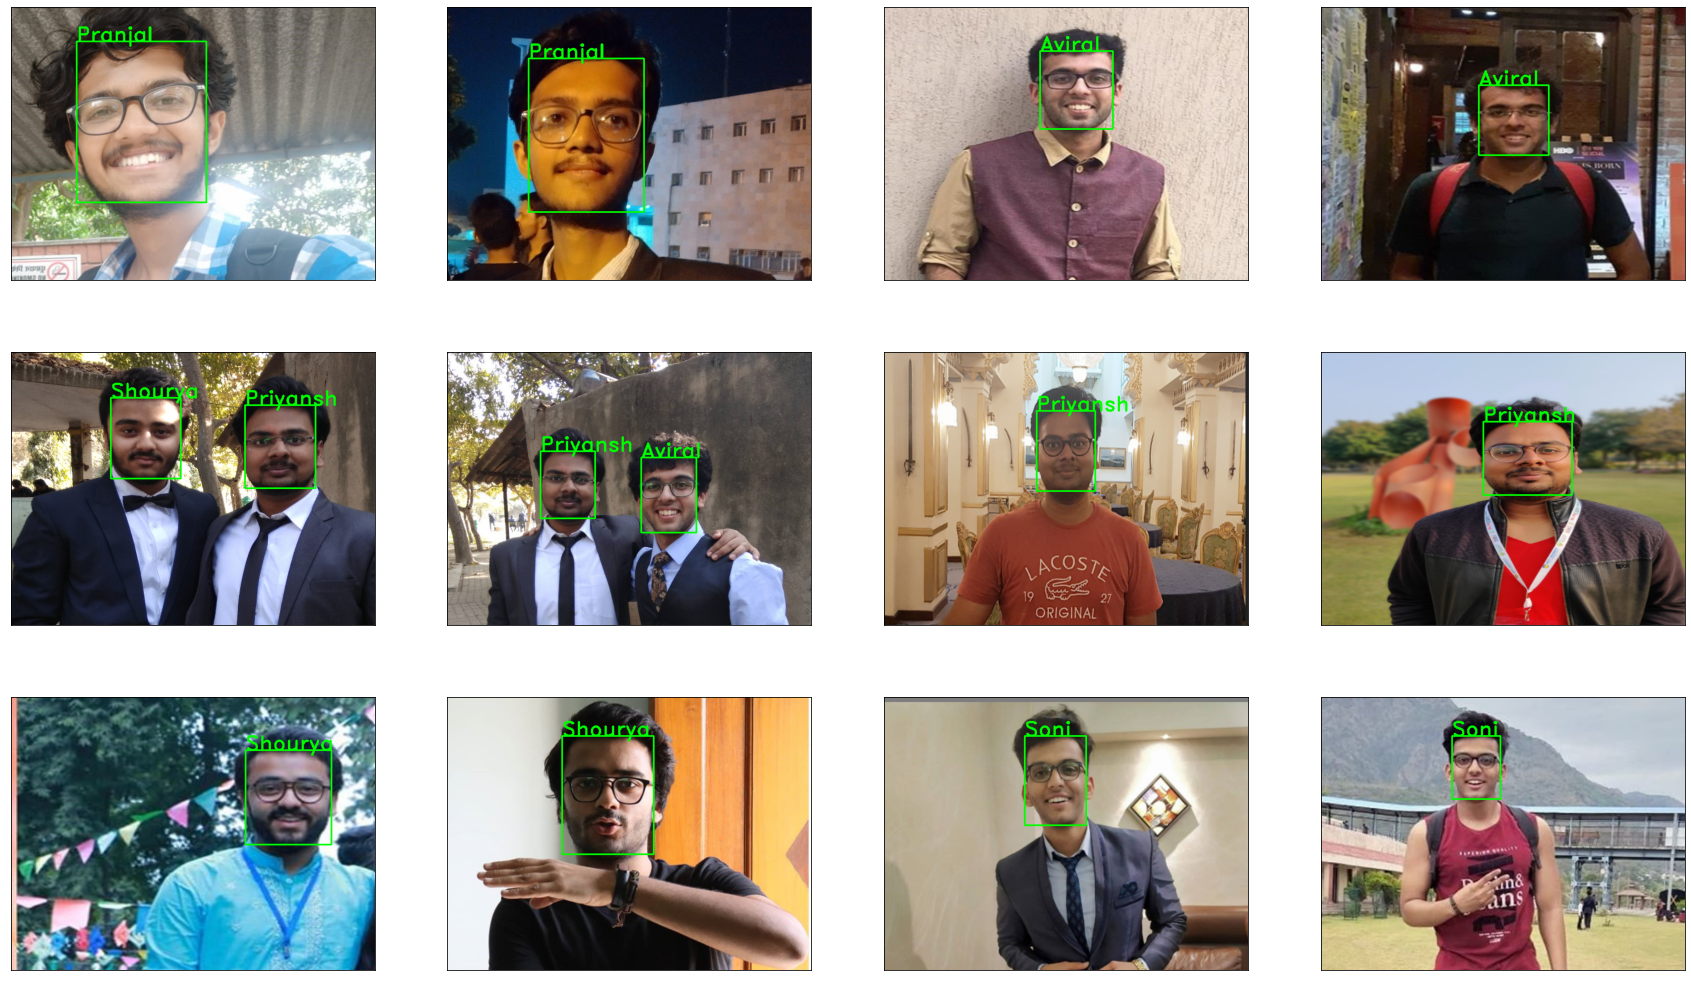

In [7]:
c = 1
fig = plt.figure(figsize = (30,18)) 
for i in imagePaths:
    image = cv2.imread(i)
    image= image_recognize(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig.add_subplot(3,4,c)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    c += 1
plt.show()

# Recognize faces in video streams

In [50]:
# using a webcam
cam = cv2.VideoCapture(1)
#out = cv2.VideoWriter('Face-Mask.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (640,480))
cam.set(3,640)
cam.set(4,480)
cam.set(10,130)

while True:
    success, image = cam.read()
    if success == True:
        image_recognize(image)
        cv2.imshow("Result", image)
        #out.write(image)
        if cv2.waitKey(1) & 0xFF == ord('a'):
            break
cam.release()
#out.release()
cv2.destroyAllWindows()